### Notebook for the label transfer of Healthy Human Heart to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230828

### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is depreca

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
absl                NA
aiohttp             3.8.4
aiosignal           1.3.1
anyio               NA
appnope             0.1.3
asttokens           NA
async_timeout       4.0.2
attr                23.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
bs4                 4.12.2
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
click               8.1.3
colorama            0.4.6
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
deepdiff            6.3.0
docrep              0.3.2
executing           1.2.0
fastapi             0.99.1
flax                0.5.0
frozenlist          1.3.3
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph   

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [5]:
reference = sc.read_h5ad('../data/hca_heart_global_ctl230828_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

- Remove annotations with less than 10 cells

In [6]:
reference.obs['seed_labels'].value_counts()

Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
nan                           23837
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: seed_labels, dtype: int64

### Subset populations of interest

In [7]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]
reference.obs['seed_labels'].value_counts()

Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: seed_labels, dtype: int64

In [8]:
reference.obs['cell_source'].value_counts()

Harvard-Nuclei    159157
Sanger-Nuclei     158453
Sanger-CD45        66925
Sanger-Cells       44134
Name: cell_source, dtype: int64

### Read in other query

In [9]:
query = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_QCed_ctl230828.raw.h5ad')
query.obs['cell_source'] = 'HIRI-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 351093 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Filter data as per diagnostic manifold

In [11]:
query = query[query.obs['n_genes'] < 6000]
query = query[query.obs['n_counts'] < 50000]
query = query[query.obs['doublet_scores'] < 0.35]
query

View of AnnData object with n_obs × n_vars = 334961 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'genotype_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Change gene symbols for label transfer

In [12]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [13]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 763630 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-reference', 'n_count

In [14]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

Unknown                      334961
Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: seed_labels, dtype: int64

In [15]:
adata.obs['batch'].value_counts()

reference    428669
query        334961
Name: batch, dtype: int64

### Select HVGs

In [16]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 763630 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-reference', 'n_counts

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [57:17<00:00, 345.63s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.91e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [57:17<00:00, 343.79s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.91e+3]


### Label transfer with `scANVI` 

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [21]:
scanvi_model.train()

INFO     Training for 3 epochs.                                                                                    


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3/3: 100%|██████████| 3/3 [21:15<00:00, 426.16s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.98e+3]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [21:15<00:00, 425.08s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.98e+3]


In [22]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [23]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:22:43)
the obs value 'sample' has more than 103 categories. Uniform 'grey' color will be used for all categories.


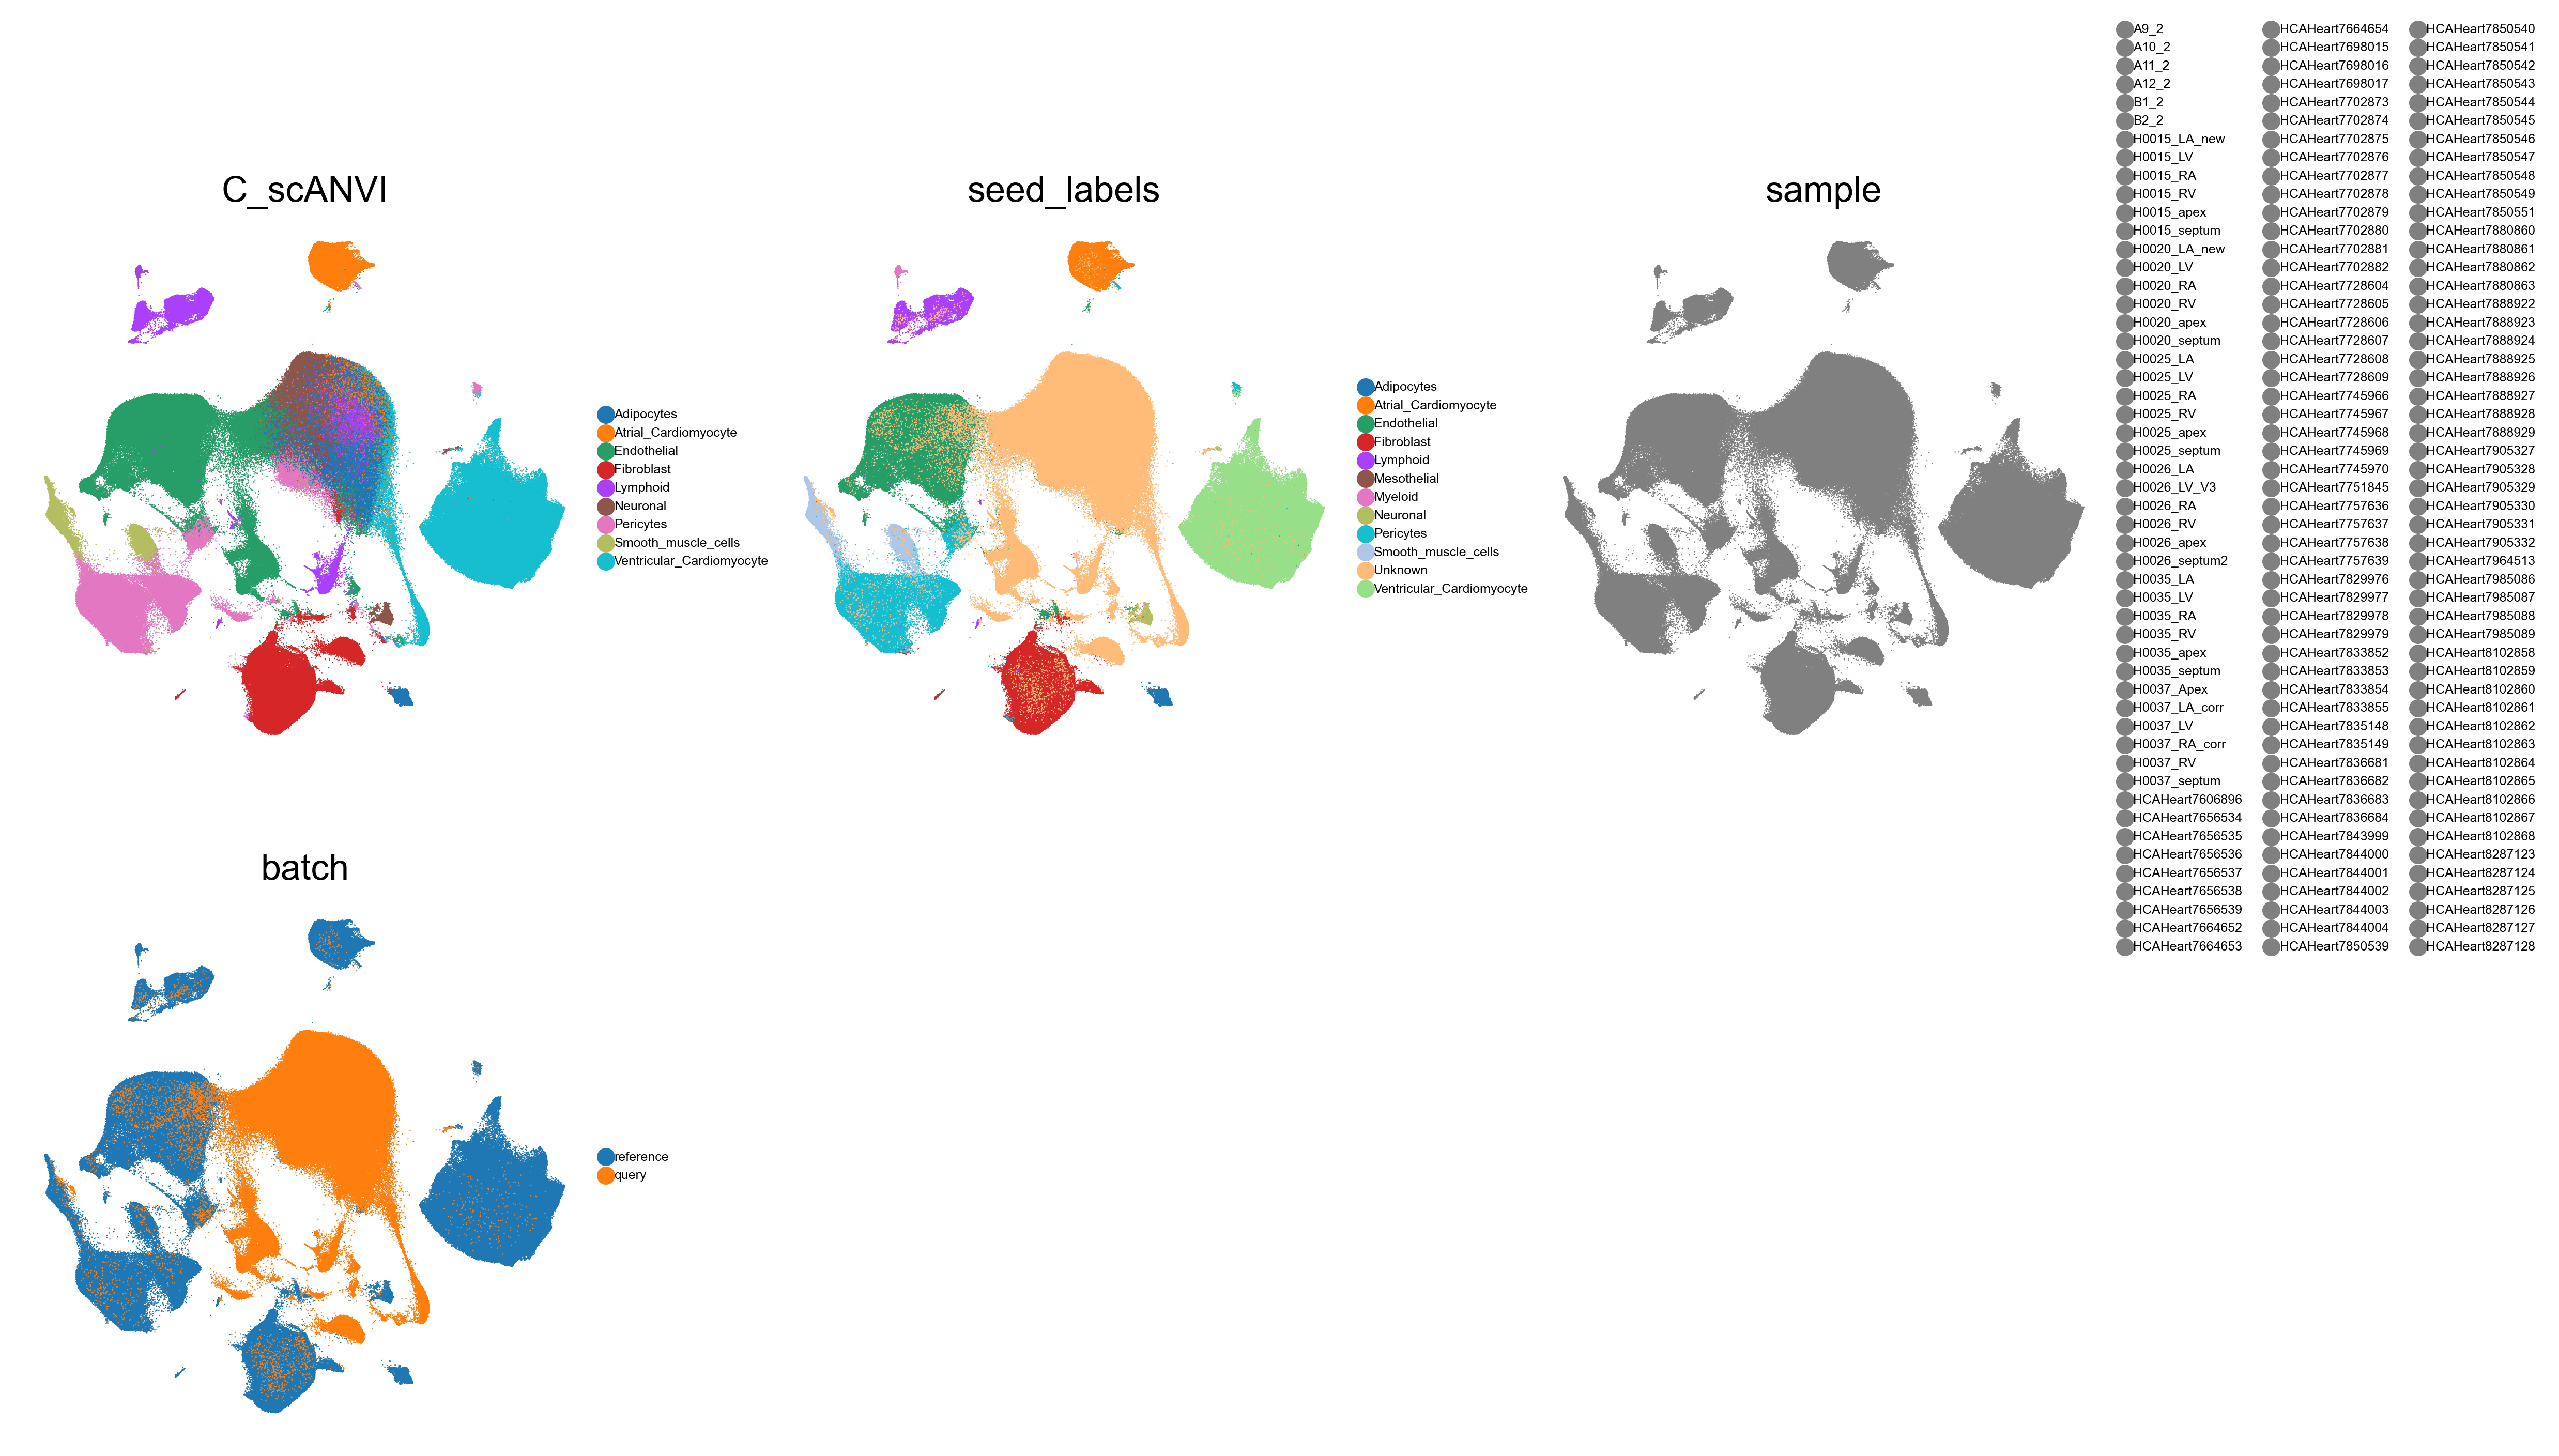

In [24]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [25]:
adata_export = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export

AnnData object with n_obs × n_vars = 763630 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-refere

In [26]:
adata_export = adata_export[adata_export.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 334961 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-ful

### Revert gene symbols

In [27]:
adata_export.var_names = [gene_name.capitalize() for gene_name in adata_raw.var_names]
adata_export.var_names

Index(['Samd11', 'Noc2l', 'Plekhn1', 'Perm1', 'Isg15', 'Agrn', 'Ttll10',
       'Tnfrsf18', 'Tnfrsf4', 'Sdf4',
       ...
       'Mt-co1', 'Mt-co2', 'Mt-atp8', 'Mt-atp6', 'Mt-co3', 'Mt-nd3', 'Mt-nd4l',
       'Mt-nd4', 'Mt-nd5', 'Mt-nd6'],
      dtype='object', length=14249)

In [28]:
adata_export.obs['C_scANVI'].value_counts()

Adipocytes                   94370
Neuronal                     84823
Endothelial                  47946
Lymphoid                     39719
Pericytes                    19436
Atrial_Cardiomyocyte         17225
Ventricular_Cardiomyocyte    14310
Fibroblast                   13430
Smooth_muscle_cells           3702
Name: C_scANVI, dtype: int64

In [29]:
adata_export.write('../data/heart_mm_nuclei-23-0092_scANVi-annot_ctl230829.raw.h5ad')